In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torch.nn.functional import cross_entropy

In [2]:
def random_initialization(layers_dims):
    """
    Inicializa los parámetros para cualquier número de capas.
    """
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l - 1], layers_dims[l]) * 0.01
        parameters[f'b{l}'] = np.zeros((1, layers_dims[l]))

    return parameters

In [3]:
def relu(x):
    return np.maximum(0, x)

In [4]:
def relu_derivative(x):
  return np.where(x > 0, 1, 0)

In [5]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [6]:
def forward_propagation(X, parameters):
    """
    Realiza la propagación hacia adelante para cualquier número de capas.
    """
    L = len(parameters) // 2  # Número de capas (W, b cuentan como dos claves por capa)
    cache = {'A0': X}

    A = X
    for l in range(1, L + 1):
        Z = np.dot(A, parameters[f'W{l}']) + parameters[f'b{l}']
        if l == L:  # Última capa: Softmax
            A = softmax(Z)
        else:  # Capas ocultas: ReLU
            A = relu(Z)
        cache[f'Z{l}'] = Z
        cache[f'A{l}'] = A

    return A, cache

def backward_propagation(X, y, cache, parameters):
    """
    Realiza la propagación hacia atrás para cualquier número de capas.
    """
    L = len(parameters) // 2  # Número de capas
    m = X.shape[0]
    gradients = {}

    # Gradientes para la última capa
    dZ = cache[f'A{L}'] - y
    for l in reversed(range(1, L + 1)):
        dW = np.dot(cache[f'A{l-1}'].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients[f'dW{l}'] = dW
        gradients[f'db{l}'] = db

        if l > 1:  # No calcular da para la primera capa
            dA = np.dot(dZ, parameters[f'W{l}'].T)
            dZ = dA * relu_derivative(cache[f'Z{l-1}'])

    return gradients

def predict(parameters, X_test, y_test):

    a3, _ = forward_propagation(X_test, parameters)
    predictions = np.argmax(a3, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, predictions)

    return predictions, accuracy

In [7]:
def cross_entropy(a3, y_true):

    m = y_true.shape[0]

    cost = -np.sum(y_true * np.log(a3 + 1e-8)) / m  

    return cost

In [8]:
class EstocasticOptimizer():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameters, grads):
        L = len(parameters) // 2

        for l in range(L):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
        return parameters

In [9]:
class AdamOptimizer():
    def __init__(self, parameters, learning_rate):
        self.v = {}
        self.s = {}
        self.learning_rate = learning_rate
        L = len(parameters) // 2

        for l in range(L):
            self.v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

            self.s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    def update(self, parameters, grads, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2
        v_corrected = {}
        s_corrected = {}

        for l in range(L):
            self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(
                grads['dW' + str(l + 1)], 2)
            self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(
                grads['db' + str(l + 1)], 2)

            s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * v_corrected[
                "dW" + str(l + 1)] / np.sqrt(self.s["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * v_corrected[
                "db" + str(l + 1)] / np.sqrt(self.s["db" + str(l + 1)] + epsilon)

        return parameters

In [10]:
def create_batches(X, Y, batch_size):
    """
    Divide los datos en lotes (batches) de tamaño batch_size.
    """
    m = X.shape[0]
    indices = np.random.permutation(m)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    batches = []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch))

    return batches

In [11]:
def model(X, Y, layers_dims, learning_rate=0.01, num_epochs=500, batch_size=32, optimizer_use="Adam", print_cost=False):
    """
    Entrena el modelo utilizando mini-batches.
    """
    L = len(layers_dims)
    costs = []
    t = 0

    parameters = random_initialization(layers_dims)
    if optimizer_use == "Adam": optimizer = AdamOptimizer(parameters, learning_rate=learning_rate)
    if optimizer_use == "Estocastic": optimizer = EstocasticOptimizer(learning_rate=learning_rate)

    for i in range(num_epochs):
        batches = create_batches(X, Y, batch_size)  # Crear lotes
        for batch in batches:
            X_batch, Y_batch = batch

            # Propagación hacia adelante
            aL, cache = forward_propagation(X_batch, parameters)

            # Costo
            cost = cross_entropy(aL, Y_batch)

            # Propagación hacia atrás
            grads = backward_propagation(X_batch, Y_batch, cache, parameters)

            # Actualización de parámetros
            t += 1
            if optimizer_use == "Adam":
                parameters = optimizer.update(parameters, grads, t)
            elif optimizer_use == "Estocastic":
                parameters = optimizer.update(parameters, grads)

        # Imprimir y registrar costos periódicamente
        if print_cost and i % 1000 == 0:
            print(f"Costo tras epoch {i}: {cost:.6f}")
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title(f"Optimizador: {optimizer_use}; Learning rate = {learning_rate}; Batch size = {batch_size}")
    plt.show()

    return parameters


In [12]:
def graficar_TSNE(X, y, iris):


    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    X_reduced = tsne.fit_transform(X)

    df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2', 'Dim3'])
    df['target'] = y

    colors = ['red', 'blue', 'green']
    target_names = iris.target_names

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, target_name in enumerate(target_names):
        ax.scatter(df.loc[df['target'] == i, 'Dim1'],
                   df.loc[df['target'] == i, 'Dim2'],
                   df.loc[df['target'] == i, 'Dim3'],
                   label=target_name, color=colors[i])

    ax.set_xlabel('Dim1')
    ax.set_ylabel('Dim2')
    ax.set_zlabel('Dim3')
    ax.set_title('Iris Dataset en 3D usando t-SNE')
    ax.legend()
    plt.show()

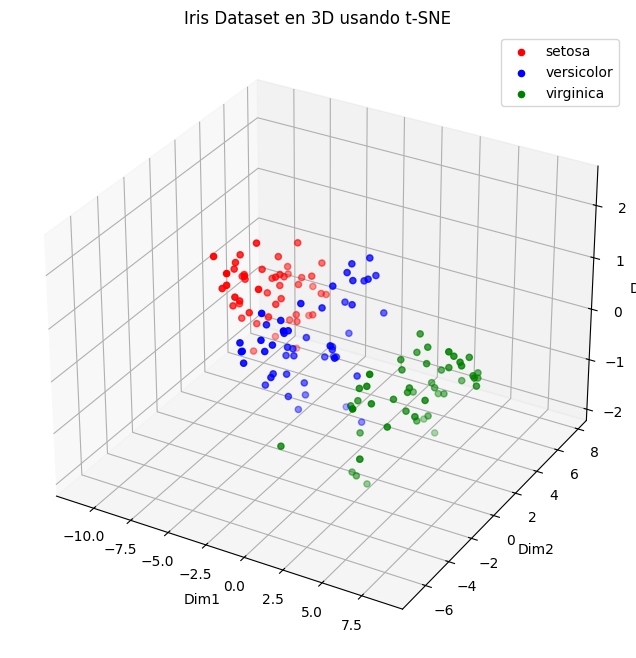

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.5    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 3.562378
Costo tras epoch 1000: 1.334154
Costo tras epoch 2000: 1.062899
Costo tras epoch 3000: 1.265694
Costo tras epoch 4000: 1.128969
Costo tras epoch 5000: 1.195188
Costo tras epoch 6000: 1.119258
Costo tras epoch 7000: 1.114023
Costo tras epoch 8000: 1.167215
Costo tras epoch 9000: 1.249765


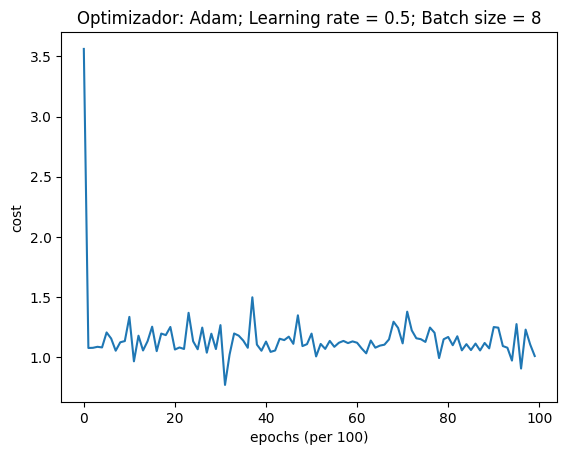

La exactitud para optimizador Adam con learning rate 0.5, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 33.333333 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.101191
Costo tras epoch 1000: 0.001169
Costo tras epoch 2000: 0.000016
Costo tras epoch 3000: 0.000009
Costo tras epoch 4000: 0.000002
Costo tras epoch 5000: 0.000002
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000002
Costo tras epoch 8000: 0.000002
Costo tras epoch 9000: 0.000003


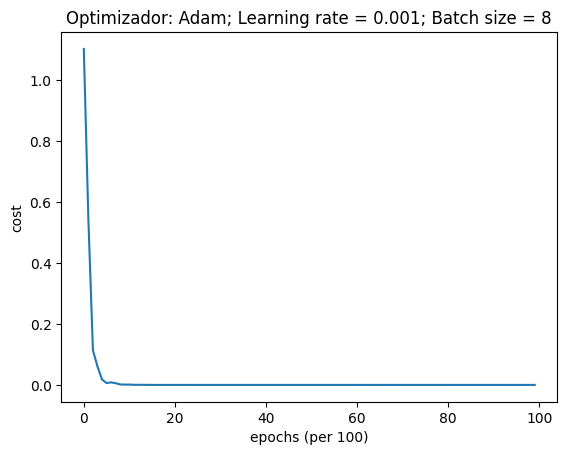

La exactitud para optimizador Adam con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.5    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.115521
Costo tras epoch 1000: 1.064527
Costo tras epoch 2000: 1.195865
Costo tras epoch 3000: 1.147094
Costo tras epoch 4000: 1.084232
Costo tras epoch 5000: 1.208871
Costo tras epoch 6000: 1.098030
Costo tras epoch 7000: 1.164220
Costo tras epoch 8000: 1.067557
Costo tras epoch 9000: 1.079901


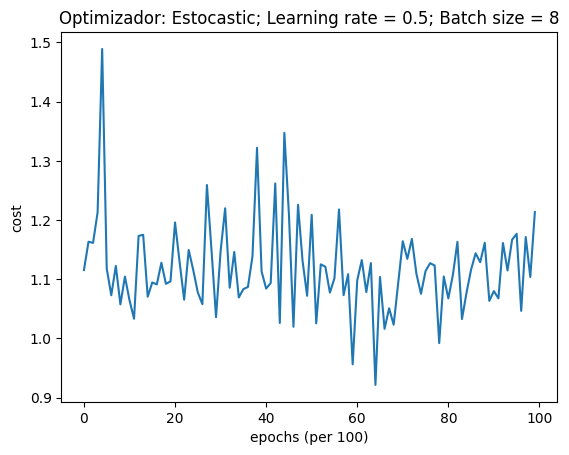

La exactitud para optimizador Estocastic con learning rate 0.5, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098384
Costo tras epoch 1000: 1.070546
Costo tras epoch 2000: 1.142819
Costo tras epoch 3000: 1.030912
Costo tras epoch 4000: 1.109623
Costo tras epoch 5000: 1.142043
Costo tras epoch 6000: 1.142526
Costo tras epoch 7000: 1.070567
Costo tras epoch 8000: 1.142390
Costo tras epoch 9000: 1.037711


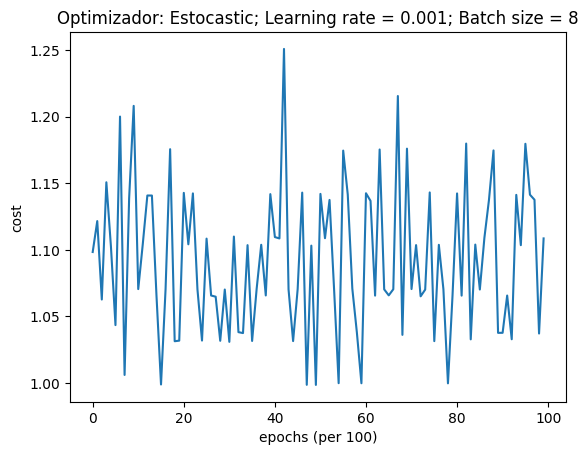

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

Claves ordenadas según el tamaño del valor:
('Adam', 0.001, 8, (4, 16, 12, 8, 3)): 0.9524
('Estocastic', 0.5, 8, (4, 16, 12, 8, 3)): 0.4762
('Estocastic', 0.001, 8, (4, 16, 12, 8, 3)): 0.4762
('Adam', 0.5, 8, (4, 16, 12, 8, 3)): 0.3333


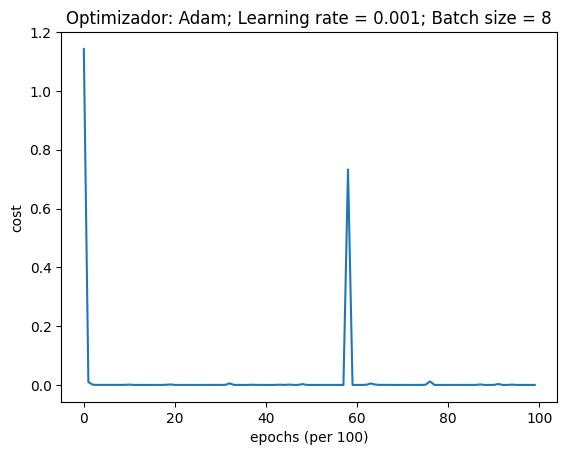

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


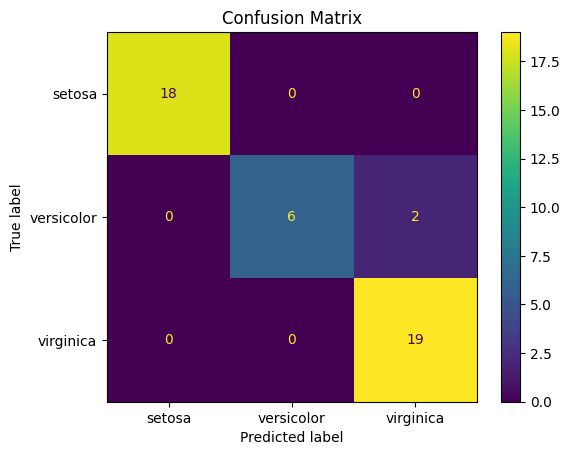

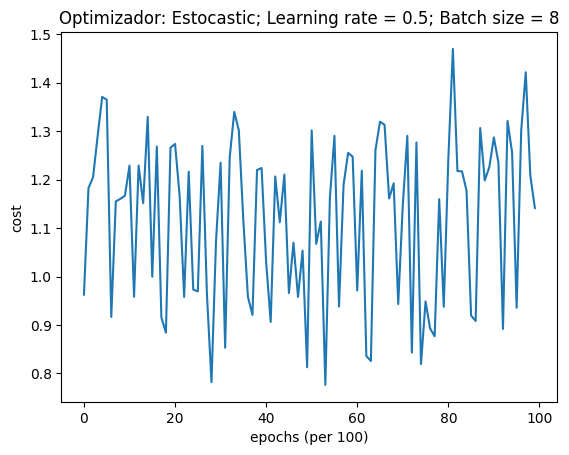

------------------------


Las predicciones son: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
La exactitud es de: 42.22 %


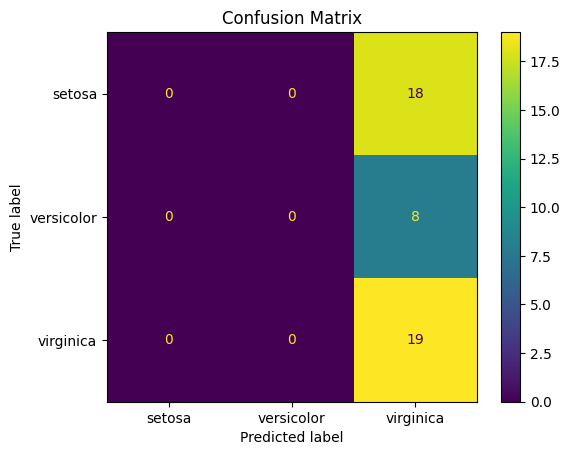

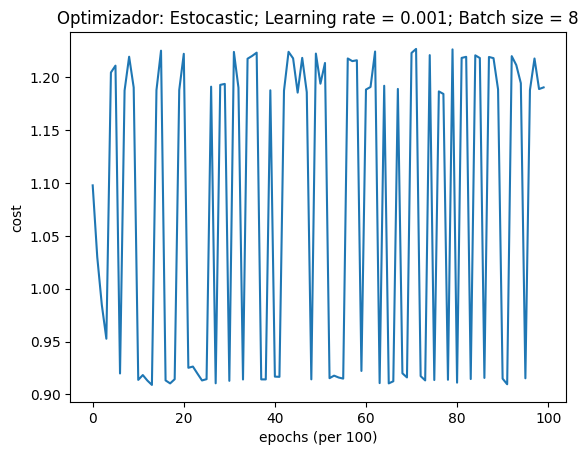

------------------------


Las predicciones son: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
La exactitud es de: 17.78 %


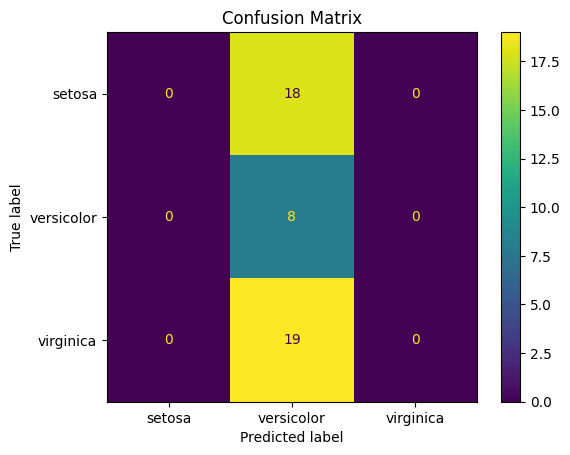

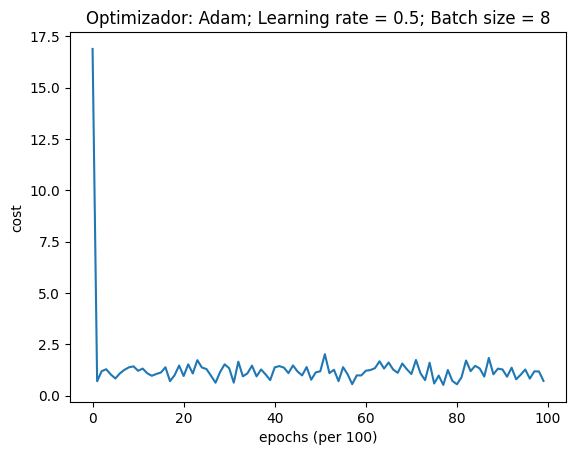

------------------------


Las predicciones son: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
La exactitud es de: 17.78 %


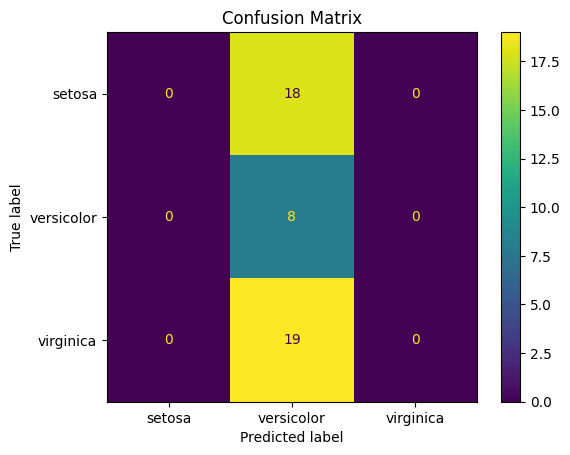

In [13]:
def initialize_data():
    iris = load_iris()
    X = iris.data
    y = iris.target.reshape(-1, 1)

    # Visualización con t-SNE
    graficar_TSNE(X, y, iris)

    # One-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y)

    # Dividir en conjuntos de entrenamiento, validación y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=156477)
    X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15477)

    return X_train, X_test, y_train, y_test, X_train_2, X_val, y_train_2, y_val

# Función principal
def model_train_and_validation(layers_dims, learning_rates, batches, X_train_2, X_val, y_train_2, y_val):

    optimizers = ['Adam', 'Estocastic']
    resultados = {}

    for layer_dim in layers_dims:
        for optimizer in optimizers:
            for learning_rate in learning_rates:
                for batch in batches:
                    print(f'------------------------\n')
                    print(f'OPTIMIZADOR: {optimizer}    LEARNING_RATE: {learning_rate}    Nº BATCHES: {batch}    ESTRUCTURA CAPAS: {layer_dim}')
                    parameters = model(
                        X_train_2, y_train_2, layer_dim,
                        optimizer_use=optimizer,
                        learning_rate=learning_rate,
                        num_epochs=10000,
                        batch_size=batch,
                        print_cost=True
                    )
                    predictions, accuracy = predict(parameters, X_val, y_val)
                    resultados[(optimizer, learning_rate, batch, layer_dim)] = accuracy
                    print(f'La exactitud para optimizador {optimizer} con learning rate {learning_rate}, nº batches {batch} y estructura de capas {layer_dim}\nes de: {accuracy*100:.6f} %')
                    print(f'------------------------\n')

    claves_ordenadas = sorted(resultados.keys(), key=lambda k: resultados[k], reverse=True)
    print("Claves ordenadas según el tamaño del valor:")
    for clave in claves_ordenadas:
        print(f"{clave}: {resultados[clave]:.4f}")

    return claves_ordenadas[:11]

def model_test(combination, X_train, X_test, y_train, y_test):
    parameters = model(
        X_train, y_train, combination[-1],
        optimizer_use=combination[0],
        learning_rate=combination[1],
        num_epochs=10000,
        batch_size=combination[2]
        )
    predictions, accuracy = predict(parameters, X_test, y_test)
    print(f'------------------------\n')
    print(f'\nLas predicciones son: {predictions}')
    print(f'La exactitud es de: {accuracy * 100:.2f} %')
    y_test_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=load_iris().target_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

X_train, X_test, y_train, y_test, X_train_2, X_val, y_train_2, y_val = initialize_data()
layers_dims = [(X_train_2.shape[1], 16, 12, 8, 3), (X_train_2.shape[1], 16, 6, 3), (X_train_2.shape[1], 16, 18, 16, 8, 3)]
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
batches = [8, 16, 32]

combinations = model_train_and_validation(layers_dims, learning_rates, batches, X_train_2, X_val, y_train_2, y_val)
for combination in combinations:
    model_test(combination, X_train, X_test, y_train, y_test)